# Kern–Frenkel model in HPMC

## Overview

### Questions
* How do I implement pairwise energetic interactions in HPMC?

### Objectives
* Implement arbitrary pairwise energetic interactions in HPMC simulations in HOOMD-Blue.

## Boilerplate code

In [16]:
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use('ggplot')

In [83]:
def draw_kern_frenkel_particle(
    ax, xy, sigma, kf_lambda, kf_delta, kf_director, draw_arrow=False):
    theta_director = numpy.rad2deg(numpy.arctan2(kf_director[1], kf_director[0]))
    wedge = matplotlib.patches.Wedge(
        xy,
        sigma*kf_lambda,
        theta_director-kf_delta,
        theta_director+kf_delta,
        alpha=0.5,
        zorder=1,
    )
    wedge = ax.add_patch(wedge)
    ax.set_axis_off()
    ax.set_aspect('equal')
    circle = matplotlib.patches.Circle(xy, sigma, fc='gray', zorder=2, ec='k')
    ax.add_patch(circle)
    
    # draw director
    if draw_arrow:
        unit_director = numpy.array(kf_director) / numpy.linalg.norm(kf_director)
        arrow = matplotlib.patches.FancyArrow(
            xy[0],
            xy[1],
            unit_director[0] * sigma*kf_lambda,
            unit_director[1] * sigma*kf_lambda,
            color='k',
            zorder=circle.get_zorder()+1,
            width=0.03,
            length_includes_head=True,
        )
        ax.add_patch(arrow)
        
    
    # adjust plot limits
    new_extent = kf_lambda*sigma + max(abs(xy[0]), abs(xy[1]))
    old_extent = ax.get_xlim()[1]
    extent = max(new_extent, old_extent)
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)


## The Kern–Frenkel model
The Kern–Frenkel model contains directional pairwise energetic interactions in addition to hard sphere-like volume exclusion.
The pair potential $u_{ij}(r_{ij}, \Omega_i, \Omega_j)$ between particles $i$ and $j$ at a center-to-center distance $r_{ij}$ and orientations $\Omega_i$ and $\Omega_j$ is of the form
$$
u_{ij}(r_{ij}, \Omega_i, \Omega_j) = u_{ij}^{\mathrm{hssw}} \cdot f(\Omega_i, \Omega_j),
$$
where $u_{ij}^{\mathrm{hssw}}$ is the hard sphere plus square well potential:
$$
u_{ij}^{\mathrm{hssw}} = 
\begin{cases}
\infty & r_{ij} < \sigma_{ij} \\
-\varepsilon & \sigma_{ij} <= r_{ij} < \lambda_{ij}\sigma_{ij} \\
0 & r_{ij} > \lambda_{ij}\sigma_{ij}
\end{cases}
$$
where $\sigma_{ij}$ is sum of the radii of particles $i$ and $j$ and $\lambda$ is the range of the square well attraction, and $f(\Omega_i, \Omega_j)$ is an orientational masking function given by
$$
f(\Omega_1, \Omega_2) = 
\begin{cases}
1 & \mathrm{any~} \hat{e}_\alpha^{(i)} \cdot \hat{r}_{ij} > \cos \delta \mathrm{~and~any~} \hat{e}_\beta^{(j)} \cdot \hat{r}_{ji} > \cos \delta \\
0 & \mathrm{otherwise}
\end{cases}
$$
where $\hat{e}_{\alpha}^{(i)}$ is the "director" of any patch $\alpha$ on particle $i$ and $\delta$ is the half-opening angle of the patch.

Graphically, this pair potential corresponds to the following criterion: two particles interact with energy $-\varepsilon$ if the blue shaded regions on the two particles overlap, $\infty$ if the gray shaded regions on the two particles overlap, and zero otherwise.

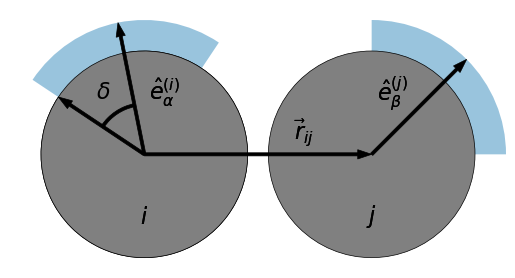

In [212]:
fig, ax = matplotlib.pyplot.subplots()
draw_kern_frenkel_particle(ax, (-1.1, 0), 1, 1.3, 45, (-0.2, 1), draw_arrow=True)
draw_kern_frenkel_particle(ax, (1.1, 0), 1, 1.3, 45, (1, 1), draw_arrow=True)
arrow = matplotlib.patches.FancyArrow(
    -1.1,
    0,
    1.1 - (-1.1),
    0,
    color='k',
    zorder=3,
    width=0.03,
    length_includes_head=True,
)
ax.add_patch(arrow)
ax.text(0.35, 0.15, r'$\vec{r}_{ij}$', size=16)
ax.text(-1.1, -0.6, r'$i$', size=16, ha='center', va='center')
ax.text(1.1, -0.6, r'$j$', size=16, ha='center', va='center')
ax.text(-0.9, 0.6, r'$\hat{e}_{\alpha}^{(i)}$', size=16, ha='center', va='center')
ax.text(1.3, 0.6, r'$\hat{e}_{\beta}^{(j)}$', size=16, ha='center', va='center')
theta = numpy.arctan2(1, -0.2) + numpy.deg2rad(45)
arrow = matplotlib.patches.FancyArrow(
    -1.1,
    0,
    numpy.cos(theta),
    numpy.sin(theta),
    color='k',
    zorder=3,
    width=0.03,
    length_includes_head=True,
)
ax.add_patch(arrow)
annulus = matplotlib.patches.Annulus((-1.1, 0), 0.5, 0.03, zorder=2, color='k')
ax.add_patch(annulus)
circle = matplotlib.patches.Wedge(
    (-1.1, 0),
    1,
    numpy.rad2deg(theta),
    numpy.rad2deg(theta + 2*numpy.pi - numpy.pi/4),
    zorder=2,
    fc='gray',
    ec='k',
)
ax.add_patch(circle)

# labels
ax.text(0.35, 0.15, r'$\vec{r}_{ij}$', size=16)
ax.text(-1.1, -0.6, r'$i$', size=16, ha='center', va='center')
ax.text(1.1, -0.6, r'$j$', size=16, ha='center', va='center')
ax.text(-0.9, 0.6, r'$\hat{e}_{\alpha}^{(i)}$', size=16, ha='center', va='center')
ax.text(1.3, 0.6, r'$\hat{e}_{\beta}^{(j)}$', size=16, ha='center', va='center')
text = ax.text(-1.5, 0.6, r'$\delta$', size=16, ha='center', va='center')
ylim = ax.set_ylim(-1.1, 1.4)

## Implementing energetic interactions in HPMC
The HPMC integrator base class `hoomd.hpmc.integrate.HPMCIntegrator` has a property `pair_potential` that allows the addition of pairwise energetic interactions in HPMC simulations via `hoomd.hpmc.pair` objects.
In this tutorial, you will add a `hoomd.hpmc.pair.user.CPPPotential` to an HPMC integrator, which enables the addition of arbitrary, user-defined pair potentials.
The C++ code that implements the Kern–Frenkel potential between two particles can be written as
```C++
// constants
const float epsilon = 1.0;
const float sigma = 1.0;  // hard core radius
const float lambda = 1.3;
const float delta = 45 * M_PI / 180;  delta in radians
const float cos_delta = cos(delta);
const vec3<float> ehat_particle_reference(1, 0, 0); patch director, unit magnitude

// relevant quantities
ehat_i = rotate(q_i, ehat_particle_reference);
ehat_j = rotate(q_j, ehat_particle_reference);
float rsq = dot(r_ij, r_ij);
vec3<float> r_hat_ij = r_ij / sqrt(rsq);  // unit vector pointing from particle i to particle j
bool patch_on_i_is_aligned = dot(ehat_i, r_hat_ij) >= cos(delta);
bool patch_on_j_is_aligned = dot(ehat_j, -r_hat_ij) >= cos(delta);

// check for patch alignment and distance criterion
if (patch_on_i_is_aligned && patch_on_j_is_aligned && rsq < 2*lambda*sigma * 2*lambda*sigma)
    {
    return -epsilon
    }
else
    {
    return 0.0;
    }
```
This code uses code from the `HOOMDMath.h` library, namely `vec3<>`s to represent vectors, `rotate` to rotate vectors, and `dot` to calculate the dot product of two vectors.

In the next section of the tutorial, you will simulate a system of particles interacting with this pair potential.

## Possible extra graphics

Hence, this pair configuation is disallowed by the hard sphere part of the potential:


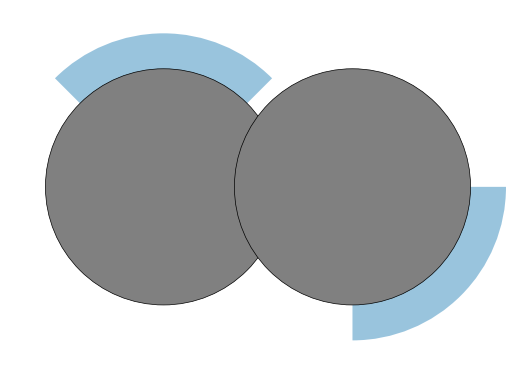

In [221]:
fig, ax = matplotlib.pyplot.subplots()
draw_kern_frenkel_particle(ax, (-0.8, 0), 1, 1.3, 45, (0, 1))
draw_kern_frenkel_particle(ax, (0.8, 0), 1, 1.3, 45, (1, -1))
ylim = ax.set_ylim(-1.5, 1.5)

The following pair configuration is interacting with energy $\varepsilon$:

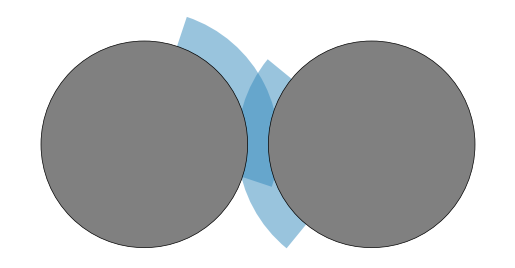

In [217]:
fig, ax = matplotlib.pyplot.subplots()
draw_kern_frenkel_particle(ax, (-1.1, 0), 1, 1.3, 45, (2, 1))
draw_kern_frenkel_particle(ax, (1.1, 0), 1, 1.3, 45, (-1, -0.1))
ylim = ax.set_ylim(-1.1, 1.3)

And the following three pair configuartions are each non-interacting:

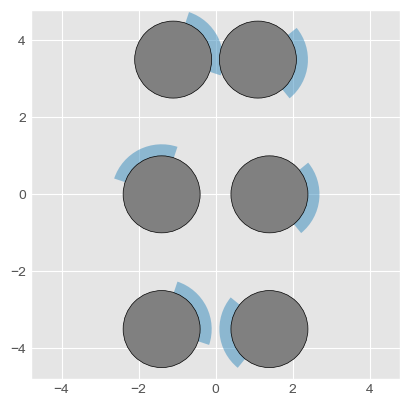

In [218]:
fig, ax = matplotlib.pyplot.subplots()
draw_kern_frenkel_particle(ax, (-1.1, 3.5), 1, 1.3, 45, (2, 1))
draw_kern_frenkel_particle(ax, (1.1, 3.5), 1, 1.3, 45, (1, -0.1))

draw_kern_frenkel_particle(ax, (-1.4, 0), 1, 1.3, 45, (-1, 2))
draw_kern_frenkel_particle(ax, (1.4, 0), 1, 1.3, 45, (1, -0.1))

draw_kern_frenkel_particle(ax, (-1.4, -3.5), 1, 1.3, 45, (2, 1))
draw_kern_frenkel_particle(ax, (1.4, -3.5), 1, 1.3, 45, (-1, -0.1))
ax.set_axis_on()